<a href="https://colab.research.google.com/github/silwalprabin/data-mining-and-machine-learning/blob/main/W8_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Synthetic RFM dataset created!
   CustomerID  Recency  Frequency  Monetary
0           1      130          1    335.36
1           2       91          1     63.48
2           3      152          3     59.28
3           4       59          6    707.93
4           5      201         11    550.88

Dataset shape: (2000, 4)

Basic statistics:
           Recency    Frequency      Monetary
count  2000.000000  2000.000000   2000.000000
mean    106.455500     7.864500    632.334800
std      58.043471    25.868025   3125.659741
min       2.000000     1.000000      4.820000
25%      61.750000     1.000000     48.460000
50%      99.000000     1.000000     97.110000
75%     147.000000     4.000000    258.340000
max     297.000000   200.000000  73277.250000


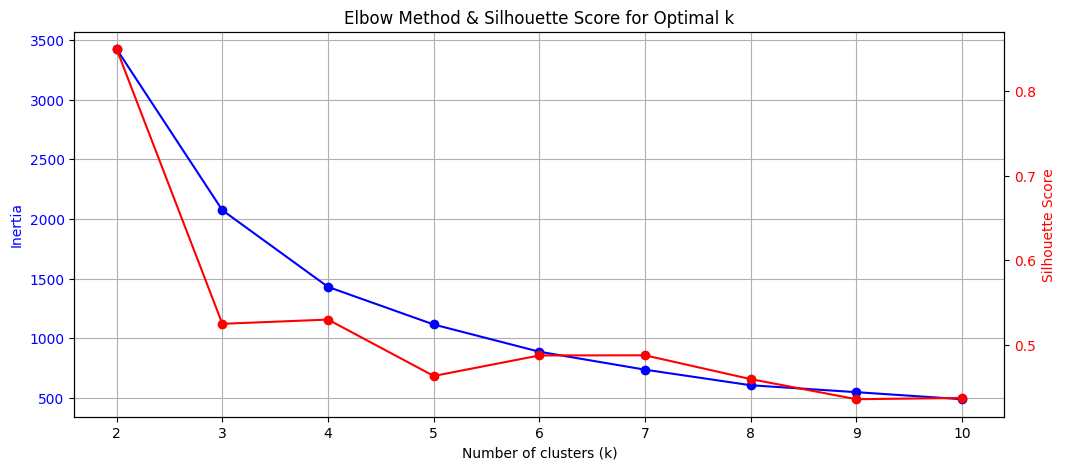


K-Means Silhouette Score (k=4): 0.530

DBSCAN found 1 clusters and 89 noise points


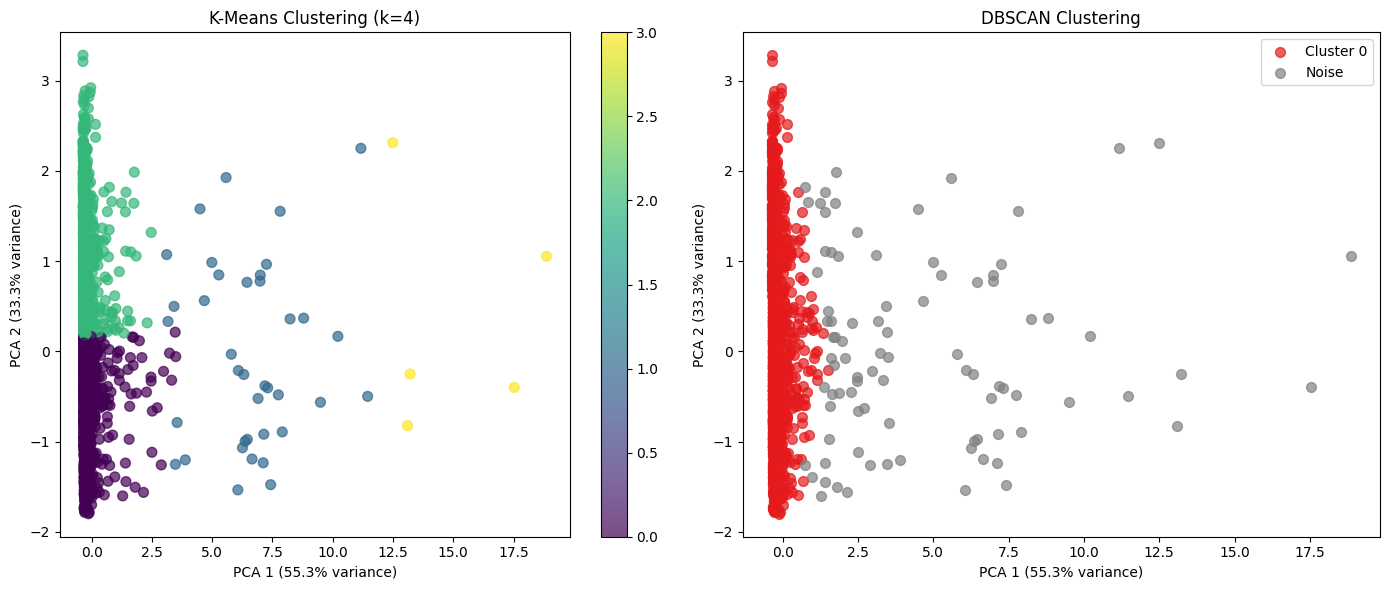


K-Means Cluster Profiles:
                Recency  Frequency  Monetary  Customers
KMeans_Cluster                                         
0                 67.43       4.44    334.76       1179
1                102.68     167.71  10284.88         38
2                165.77       4.26    303.50        778
3                109.40     161.00  48606.98          5

Interpreted K-Means Clusters:
                                               Recency  Frequency  Monetary  \
KMeans_Cluster                                                                
Champions (Low Recency, High Freq & Monetary)    67.43       4.44    334.76   
Loyal Customers                                 102.68     167.71  10284.88   
At Risk                                         165.77       4.26    303.50   
Lost / Hibernating                              109.40     161.00  48606.98   

                                               Customers  
KMeans_Cluster                                            
Champions (Lo

In [1]:
# RFM (Recency, Frequency, Monetary) segmentation groups

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# 1. E-commerce dataset
# -----------------------------
np.random.seed(42)
n_customers = 2000

# Recency: days since last purchase (1–365)
recency = np.random.beta(2, 5, n_customers) * 365
recency = recency.astype(int) + 1

# Frequency: number of purchases in the last year
frequency = np.random.zipf(1.8, n_customers)
frequency = np.clip(frequency, 1, 200)  # cap extreme outliers

# Monetary: total spend (correlated with frequency)
monetary = frequency * np.random.lognormal(mean=4, sigma=0.8, size=n_customers)
monetary = monetary.round(2)

# Create DataFrame
df = pd.DataFrame({
    'CustomerID': range(1, n_customers + 1),
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
})

print("RFM dataset!")
print(df.head())
print("\nDataset shape:", df.shape)
print("\nBasic statistics:")
print(df[['Recency', 'Frequency', 'Monetary']].describe())

# Save if you want a real CSV for later use
df.to_csv('ecommerce_rfm.csv', index=False)

# -----------------------------
# 2. Prepare features for clustering
# -----------------------------
features = ['Recency', 'Frequency', 'Monetary']
X = df[features]

# Standardize (very important for K-Means and also for DBSCAN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 3. K-Means Clustering – find optimal number of clusters
# -----------------------------
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow & Silhouette
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(K_range, silhouettes, 'ro-')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Elbow Method & Silhouette Score for Optimal k')
plt.show()

# Choose optimal k (example: 4 clusters is often good for RFM)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nK-Means Silhouette Score (k={optimal_k}): {silhouette_score(X_scaled, df['KMeans_Cluster']):.3f}")

# -----------------------------
# 4. DBSCAN Clustering
# -----------------------------
# eps ≈ 0.3–0.7 works well on standardized RFM data; adjust based on k-distance plot
db = DBSCAN(eps=0.5, min_samples=10)  # min_samples ≈ 2×dimensions or higher for robustness
df['DBSCAN_Cluster'] = db.fit_predict(X_scaled)

n_clusters_db = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)

print(f"\nDBSCAN found {n_clusters_db} clusters and {n_noise} noise points")

# -----------------------------
# 5. Visualization with PCA (2D)
# -----------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(14, 6))

# K-Means
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['KMeans_Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter)

# DBSCAN
plt.subplot(1, 2, 2)
colors = plt.cm.Set1(np.linspace(0, 1, len(set(db.labels_))))
for label in set(db.labels_):
    color = 'gray' if label == -1 else colors[label]
    plt.scatter(X_pca[df['DBSCAN_Cluster'] == label, 0],
                X_pca[df['DBSCAN_Cluster'] == label, 1],
                label=f'Cluster {label}' if label != -1 else 'Noise',
                s=50, c=[color], alpha=0.7)
plt.title('DBSCAN Clustering')
plt.xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------
# 6. Cluster profiles (very useful for business)
# -----------------------------
df_profile = df.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
df_profile['Customers'] = df.groupby('KMeans_Cluster').size()
df_profile = df_profile.round(2)
print("\nK-Means Cluster Profiles:")
print(df_profile)

# Example interpretation names
cluster_names = {
    0: "Champions (Low Recency, High Freq & Monetary)",
    1: "Loyal Customers",
    2: "At Risk",
    3: "Lost / Hibernating"
}
df_profile.index = df_profile.index.map(cluster_names.get)
print("\nInterpreted K-Means Clusters:")
print(df_profile)